# Explore

This file demonstrates the code

In [1]:
import dependencies
import soft_dependencies

Python Version 3.9.12 (main, Apr  5 2022, 01:53:17) 
[Clang 12.0.0 ]
Numpy Version 1.21.5
Scipy Version 1.7.3
Sklearn Version 1.0.2
Matplotlib Version 3.5.1
Line Profiler Version 3.3.1
Memory Profiler Version 0.58.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import line_profiler
import memory_profiler

np.set_printoptions(precision=3, suppress=True)
%load_ext line_profiler
%load_ext memory_profiler
%load_ext autoreload
%autoreload 2

In [3]:
from Scripts.generate_data import generate_Ys, generate_batched_Ys
from Scripts.scBiGLasso import scBiGLasso
from Scripts.utilities import generate_confusion_matrices
from Scripts.utilities import precision, recall, accuracy

## Explore Results
How good is it?  Does it work like we expect?

In [16]:
# Standard way to generate matrix variate data
Psi_gen, Theta_gen, Ys = generate_Ys(
    m=100,
    p=(p:=100),
    n=(n:=100),
    expected_nonzero_psi=n**2 / 5,
    expected_nonzero_theta=p**2 / 5,
    structure="Kronecker Sum"
)
Ys.shape

(100, 100, 100)

In [ ]:
# Can also generate it in batches
# Unfortunately this isn't so useful, as it would only notably speed up
# results for large n/p, but it runs out of memory for large n/p
# (My computer runs out if n=p=100, batches=5 for example)
Psi_gen, Theta_gen, Ys = generate_matrix_variate_data(
    m=10,
    n=(n:=20),
    p=(p:=20),
    expected_nonzero_psi=n**2 / 5,
    expected_nonzero_theta=p**2 / 5,
    size=10,
    structure="Kronecker Sum"
)
display(Ys.shape)

# Remove batches so that results can be used elsewhere
Psi_gen = Psi_gen[0, ...]
Theta_gen = Theta_gen[0, ...]
Ys = Ys[0, ...]

In [7]:
Psi, Theta = scBiGLasso(
    N = 100,
    eps = 10e-4,
    Ys = Ys,
    beta_1 = 0.7, #For perfect precision: .4 for Kron Prod, .7 for Kron Sum
    beta_2 = 0.7
)
print("===Psi===")
print(Psi_cm := generate_confusion_matrices(Psi, Psi_gen, mode='Negative'))
print(
    f"{precision(Psi_cm)=:.3f}",
    f"\n{recall(Psi_cm)=:.3f}",
    f"\n{accuracy(Psi_cm)=:.3f}"
)
print("\n==Theta==")
print(Theta_cm := generate_confusion_matrices(Theta, Theta_gen, mode='Negative'))
print(
    f"{precision(Theta_cm)=:.3f}",
    f"\n{recall(Theta_cm)=:.3f}",
    f"\n{accuracy(Theta_cm)=:.3f}"
)

===Psi===
[[   0.    0.]
 [ 424. 3116.]]
precision(Psi_cm)=1.000 
recall(Psi_cm)=0.000 
accuracy(Psi_cm)=0.880

==Theta==
[[   0.    0.]
 [ 506. 3034.]]
precision(Theta_cm)=1.000 
recall(Theta_cm)=0.000 
accuracy(Theta_cm)=0.857


## Explore Performance
How fast is it?  How much memory does it use?

<font size=-1>_You have to run these cells yourself to see results_</font>

In [6]:
# Time to generate data
from Scripts.generate_data import matrix_normal_ks
kwargs_gen = {
    'm': 100,
    'p': (p:=100),
    'n': (n:=100),
    'structure': 'Kronecker Sum',
    'expected_nonzero_psi': n**2 / 5,
    'expected_nonzero_theta': p**2 / 5
}
%lprun -f generate_Ys -f matrix_normal_ks generate_Ys(**kwargs_gen)

In [17]:
# Time to run scBiGLasso
from Scripts.scBiGLasso import _scBiGLasso_internal, _calculate_A
from Scripts.utilities import LASSO

kwargs = {
    "N": 100,
    "eps": 10e-3,
    "Ys": Ys,
    "beta_1": 0.7,
    "beta_2": 0.7
}
%lprun -f scBiGLasso -f _scBiGLasso_internal -f LASSO -f _calculate_A scBiGLasso(**kwargs)

In [10]:
# Info on memory usage
# Honestly, the results don't seem useful?
%mprun -f scBiGLasso -f _scBiGLasso_internal -f _calculate_A scBiGLasso(**kwargs)

# Explore Results
How does it do for different $\beta$?  For different densities?

<font size=-1>_(May take a while to run)_</font>

In [8]:
from Scripts.experiments import create_precision_recall_curves

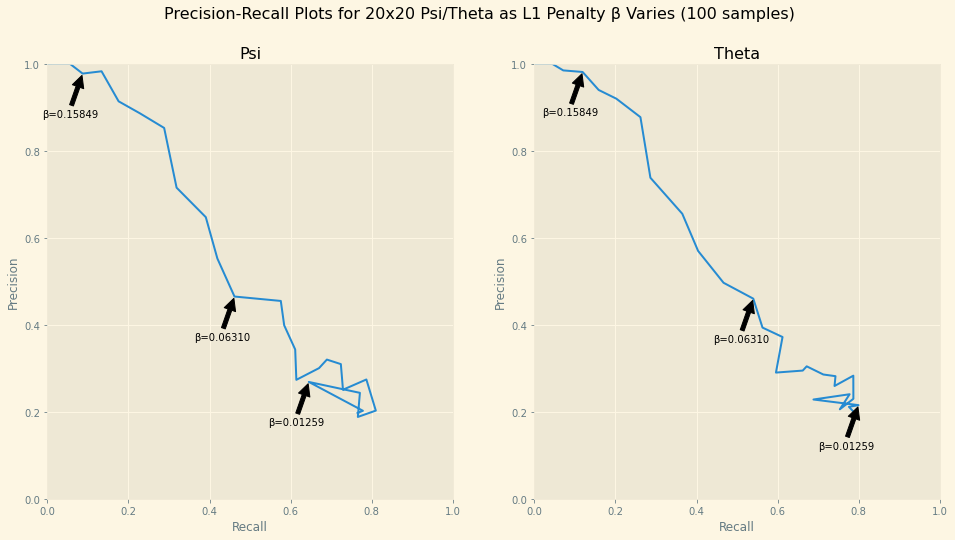

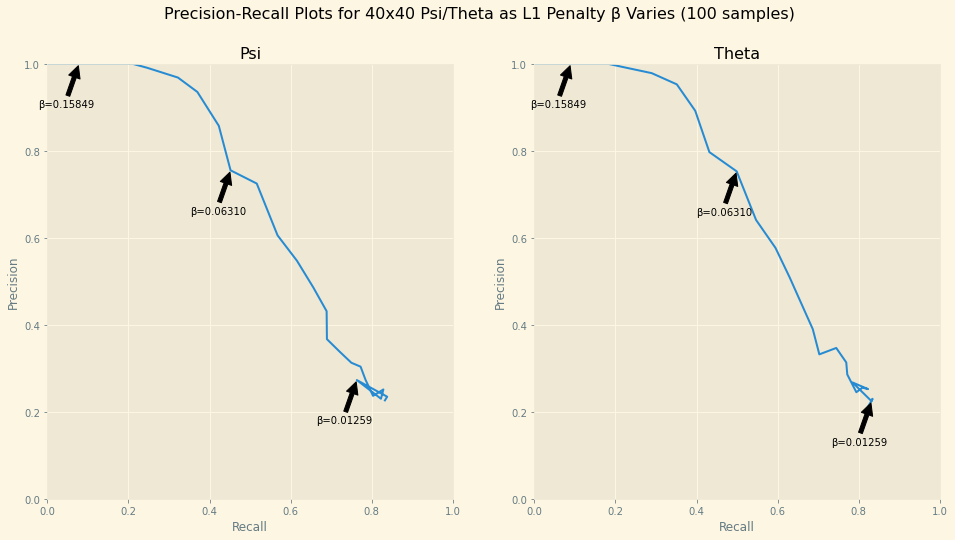

ValueError: Diagonals should not contain zeros

In [19]:
# How does choice of betas and matrix size affect results?
sizes = [20, 40, 60, 80, 100]
betas = [
    10**np.arange(-2, 0, 0.05), # 20
    10**np.arange(-2, 0, 0.05), # 40
    10**np.arange(-1, 1, 0.05), # 60
    10**np.arange(-1, 1, 0.1), # 80
    10**np.arange(-1, 1, 0.1) # 100
]
interesting_indices = [
    [2, 16, 24],
    [2, 16, 24],
    [2, 12, 16],
    [2, 6, 10],
    [2, 6, 10, 14]
]
vary_sizes_experiment = dict({})
for idx, size in enumerate(sizes):
    fig, axs, dicts = create_precision_recall_curves(
        betas[idx],
        100,
        size,
        attempts=25,
        indices_to_highlight=interesting_indices[idx]
    )
    vary_sizes_experiment[size] = dicts
    fig.savefig(f'../Plots/Vary-Sizes-Experiment/Precision-Recall-Vary-Sizes-{size}')
    display(fig) # Force figure to display NOW (`fig.show()` does not do this)
    plt.close(fig) # Suppress double-displaying the figure
np.save('../Data/Vary-Sizes-Experiment/Precisions-and-Recalls.npy', vary_sizes_experiment) 
    
# Observation: the larger the size, the more 'stable' the results are, as in
# the precision-recall curve is smoother

In [ ]:
samples = [1, 2, 5, 10, 20, 50, 100]
vary_samples_experiment = dict({})
for idx, sample in enumerate(samples):
    fig, axs, dicts = create_precision_recall_curves(
        10**np.arange(-1, 1, 0.05),
        sample,
        50,
        attempts=25,
        indices_to_highlight=[2, 12, 16, 24],
        verbose=False
    )
    vary_sizes_experiment[sample] = dicts
    fig.savefig(f'../Plots/Vary-Samples-Experiment/Precision-Recall-Vary-Samples-{sample}')
    display(fig) # Force figure to display NOW (`fig.show()` does not do this)
    plt.close(fig) # Suppress double-displaying the figure
np.save('../Data/Vary-Samples-Experiment/Precisions-and-Recalls.npy', vary_sizes_experiment) 

# Observation: it seems like low sample counts take longer to converge